# **Finding Lane Lines on the Road** 


In this project we use tools such as color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform to detect lane lines. 

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> First we detect line segments </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Then we connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [29]:
#importing some useful packages
import math
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib nbagg
%matplotlib inline

The image dimesions are (540, 960, 3)


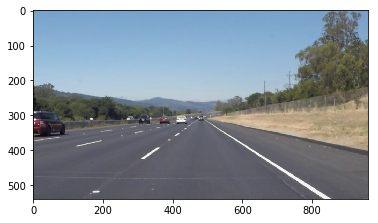

In [30]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('The image dimesions are', image.shape)
plt.imshow(image) 

In [31]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

prev_right = []
prev_left = []
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):

    xy_right =[]
    xy_left = []
    m_R = []
    m_L = []
    m_R_ave = 0.5
    m_L_ave = -0.7
    slope_R = 0.5
    slope_L = -0.7
    Intersect_R = 0
    Intersect_L = 0
        
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2 - y1)/(x2 - x1)
            if m > 0.1 and abs(m - m_R_ave) <= 0.1:# 
                m_R.append(m)
                m_R_ave = np.mean(m_R)
                if not np.isnan(m) or not np.isinf(m):
                    xy_right.append((x1,y1))
                    xy_right.append((x2,y2))
                    
                    
            elif m < -0.1 and abs(m - m_L_ave) <= 0.1:# and 
                m_L.append(m)
                m_L_ave = np.mean(m_L)
                if not np.isnan(m) or not np.isinf(m):
                    xy_left.append((x1,y1))
                    xy_left.append((x2,y2))
                                
    
    if len(xy_right) > 0:        
        [vx_R, vy_R, cx_R, cy_R ]= cv2.fitLine(np.array(xy_right, dtype=np.int32), cv2.DIST_L2,0,0.01,0.01)
        slope_R = vy_R/vx_R
        Intersect_R = cy_R - (slope_R * cx_R)
        prev_right.append([slope_R, Intersect_R])        
   
    if len(xy_left) > 0:
        [vx_L, vy_L, cx_L, cy_L]= cv2.fitLine(np.array(xy_left, dtype=np.int32), cv2.DIST_L2,0,0.01,0.01)
        slope_L = vy_L/ vx_L
        Intersect_L = cy_L - (slope_L * cx_L)
        prev_left.append([slope_L, Intersect_L])  
        
    if len(prev_right) > 0:
        slope_R, Intersect_R = np.mean(prev_right, axis = 0)

    
    if len(prev_left) > 0:
        slope_L, Intersect_L = np.mean(prev_left, axis = 0)    

    if not np.isnan(slope_R) and not np.isinf(Intersect_R):
        y_R = img.shape[0] 
        x_R = int((y_R - Intersect_R )/slope_R)
        y_R_u = y_R/1.6
        x_R_u = int((y_R_u - Intersect_R)/slope_R)
        cv2.line(img, (int(x_R), int(y_R)), (int(x_R_u), int(y_R_u)), (225, 0, 0),thickness)
    
    if not np.isnan(slope_L) and not np.isinf(Intersect_L): 
        y_L = img.shape[0] 
        x_L= int((y_L - Intersect_L)/slope_L)
        y_L_u = y_L /1.6
        x_L_u = int((y_L_u - Intersect_L)/slope_L)
        cv2.line(img, (int(x_L_u), int(y_L_u)), (int(x_L), int(y_L)), (225, 0, 0), thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    # Line is a [n][1][4] dimention array
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

First we build the pipeline to work on the images in the directory "test_images"before trying it with video files.

In [32]:
os.listdir("test_images/")

['.DS_Store',
 'solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg']

In [33]:
# This is the pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def get_roi(w, h):
    v1 = (int(w*.11),int(h))
    v2 = (int(w*.44),int(h*.60))
    v3 = (int(w*.57),int(h*.60))
    v4 = (int(w*.97),int(h))
    return([[v1,v2,v3,v4]])

def my_pipeline(image):#image_name):
#    image = mpimg.imread(image_name)
    gray = grayscale(image)
     
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    blur_gray = gaussian_blur(gray,kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    #vertices = np.array([[(105,image.shape[0]),(422, 324), (547, 324), (931,image.shape[0])]], dtype=np.int32)
    vertices = np.array(get_roi(image.shape[1],image.shape[0]), dtype=np.int32)
    #cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = region_of_interest(edges,vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 #minimum number of pixels making up a line  -100
    max_line_gap = 160    # maximum gap in pixels between connectable line segments - 160
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = weighted_img(image, line_image, α=0.8, β=1., λ=0.)
    return lines_edges
    #plt.imshow(lines_edges)


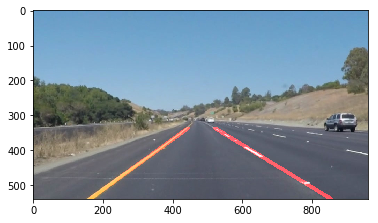

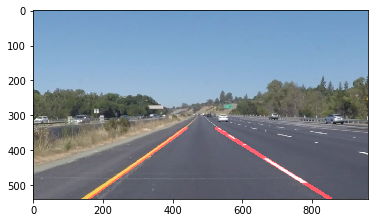

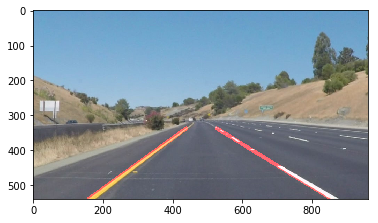

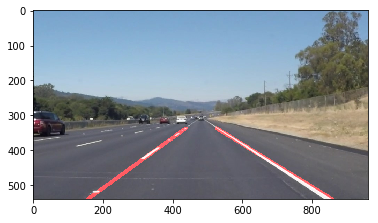

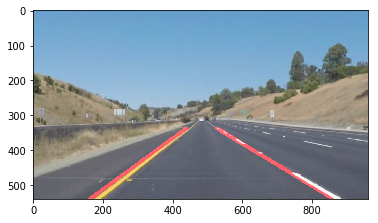

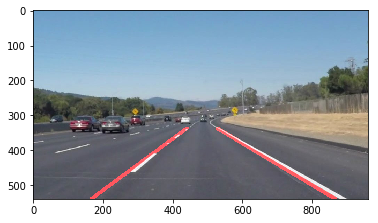

In [23]:
image_list = os.listdir("test_images/")
prev_right.clear()
prev_left.clear()
for i in range(1, len(image_list)):
    image_name = "test_images/"+image_list[i]
    image = mpimg.imread(image_name)
    plt.figure()
    plt.imshow(my_pipeline(image))#"test_images/"+name))


## Test on Videos

Now we would like to draw lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`


In [34]:
prev_right.clear()
prev_left.clear()
def process_image(image):
    # The outputis a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes) 
    return my_pipeline(image)


Let's try the one with the solid white lane on the right first ...

In [35]:
prev_right.clear()
prev_left.clear()
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 43.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.87 s, sys: 363 ms, total: 3.24 s
Wall time: 5.84 s


Play the video inline:

In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

At this point, we have the Hough line segments drawn onto the road, but now we want to define a line to run the full length of the visible lane based on the line segments we identified with the Hough Transform.  

In [37]:
prev_right.clear()
prev_left.clear()
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:16<00:00, 40.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.62 s, sys: 1.42 s, total: 11 s
Wall time: 17.4 s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge
The hardest part for me was optimizing the whole pipeline. I Spend a whole day trying to filtering out unwanted lines's data from hough_line. 
About the challenge, Idon't have much time left to work on it, but  I have a guess that problem is coming up from Canny edge detection, mainly. Since it mixes the edges from all sort of lines in the image. However, again filtering must be a challenge too. 

In [39]:
prev_right.clear()
prev_left.clear()
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:13<00:00, 18.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 6.98 s, sys: 1.65 s, total: 8.62 s
Wall time: 15.1 s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Reflections

I had such a hard time to make the challenge video work. However thanks to the encouraging 
comments of my reviewer Sedar Olmez, and also some feedback by my classmates, I kept working
on it until I got the result I was looking for. 
Regarding my thoughts, I simply tried to implement a feedback loop and keep track of previous lines 
information to reduce the steady state error after relizing dividing right and left line's (x,y) just
by the sign of slope simply was not enough. The challenging part was to figure out my bug. I have been 
mixing my set point (The desirable slopes for right and line) with my feedback system input. 
I was making a mistake by updating my average slope at the end of loop, after comparing upcoming slopes
with the old average slope.  Although now my algorithm works fine with pictures and challenge video, I 
am not sure why in only the very first frame of my white and yello video, at the very begining one the 
lines is a bit off. 

